## Wizualizacja danych: Projekt 2
## Jakie cechy dobrze różnicują firmy, które kontynuują działalność gospodarczą w okresie 12 miesięcy od tych, które działalności nie kontynuują?
[zmienna Target]
### Ewaluacja modelu LightGBM

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix

import lightgbm as lgb
from lightgbm import LGBMClassifier

import sys; sys.path.insert(0, '..')
from utils import evaluate

RANDOM_SEED = 1
np.random.seed(RANDOM_SEED)

In [2]:
SAMPLE = None

data = pd.read_csv("../data/ceidg_data_classif.csv")
if SAMPLE:
    data = data.sample(SAMPLE)
print(data.shape)
data.head()

(2401055, 30)


,RandomDate,MonthOfStartingOfTheBusiness,QuarterOfStartingOfTheBusiness,MainAddressVoivodeship,MainAddressCounty,MainAddressTERC,CorrespondenceAddressVoivodeship,CorrespondenceAddressCounty,CorrespondenceAddressTERC,MainAndCorrespondenceAreTheSame,...,ShareholderInOtherCompanies,PKDMainSection,PKDMainDivision,PKDMainGroup,PKDMainClass,NoOfUniquePKDSections,NoOfUniquePKDDivsions,NoOfUniquePKDGroups,NoOfUniquePKDClasses,Target
0,2018-03-26,May,2,MAZOWIECKIE,WARSZAWA,1465011.0,NaN,NaN,NaN,False,...,False,NaN,NaN,NaN,NaN,0,0,0,0,False
1,2018-01-10,June,2,MAZOWIECKIE,WARSZAWA,1465078.0,MAZOWIECKIE,WARSZAWA,1465078.0,True,...,False,M,71.0,711.0,7112.0,4,6,10,13,False
2,2018-03-23,June,2,MAZOWIECKIE,WARSZAWA,1465011.0,MAZOWIECKIE,WARSZAWA,1465011.0,True,...,False,C,14.0,141.0,1412.0,5,6,14,21,False
3,2018-02-13,April,2,MAZOWIECKIE,WARSZAWA,1465011.0,MAZOWIECKIE,WARSZAWA,1465011.0,True,...,False,G,46.0,461.0,4619.0,2,5,8,11,False
4,2018-03-06,December,4,MAZOWIECKIE,WARSZAWA,1465078.0,MAZOWIECKIE,WARSZAWA,1465078.0,True,...,False,C,11.0,110.0,1107.0,3,19,31,44,False


In [11]:
### DATA PREPROCESSING
categorical_variables = [
    "MonthOfStartingOfTheBusiness", 
    "MainAddressVoivodeship",
    "CorrespondenceAddressVoivodeship",
    "CorrespondenceAddressCounty",
    "PKDMainSection",
    "Sex",
    "MainAddressCounty", 
    "CommunityProperty"
]

for col in categorical_variables:
    data[col] = data[col].astype('category')

x_train, x_test, y_train, y_test = train_test_split(data.drop(["Target", "RandomDate"], axis=1), data["Target"], random_state=RANDOM_SEED)
print("Percentage of ones in target: {:.2f}% train, {:.2f}% test".format(y_train.mean()*100, y_test.mean()*100))

Percentage of ones in target: 17.23% train, 17.21% test


In [13]:
d_train = lgb.Dataset(x_train, label=y_train)
d_test = lgb.Dataset(x_test, label=y_test)

clf = LGBMClassifier(n_estimators=1000)
clf.fit(x_train, y_train)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=1000, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

Accuracy: 83.02
F-1 score: 0.1001


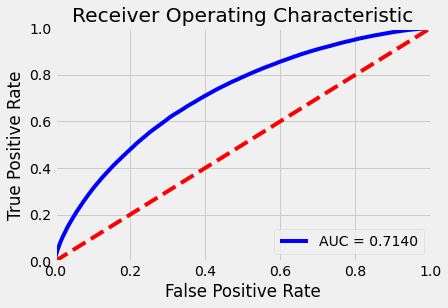

In [14]:
evaluate(clf, x_test, y_test);

In [15]:
y_pred = clf.predict(x_test)
confusion_matrix(y_test, y_pred)

array([[492670,   4314],
       [ 97614,   5666]])

---
#### What features are important?

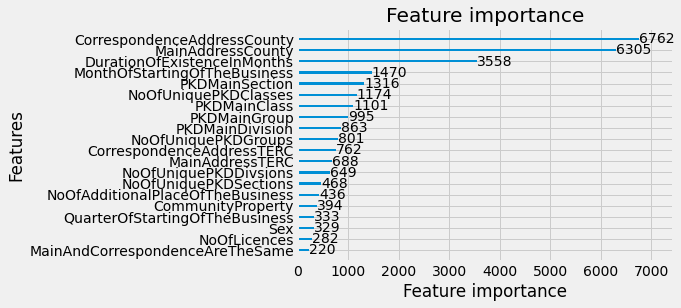

In [16]:
lgb.plot_importance(clf, max_num_features=20)